In [1]:
import numpy as np
import json

import tqdm as tqdm

from simplequantnetsim.protocols import MPC_protocol, MPG_protocol, SP_protocol
from simplequantnetsim.graph import network, set_edge_length, update_graph_params

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
mkr = ["x", "+", "d", "o", "1", "2"] + ["x"] * 100
dashs = ["-.", "--", ":", "-"] + ["-"] * 100
cols = ["gray", "g", "b", "orange", "r", "k", "purple"] + ["k"] * 100
linewidth = 2.2
mks = 5.5
fontsize = 14

# ER against length for the MPC, MPG, and SP protocols

In [3]:
size = 5
center = (size - 1) / 2
G = network(size, size)
nodes = list(G.nodes)
protocols = [MPC_protocol, MPG_protocol, SP_protocol]

In [4]:
length_range = np.linspace(0, 100, 200)
ER = np.zeros((len(protocols), len(length_range)))
timesteps = 1000
reps = 200
Q_c = 1
p_op = 1
loss_dB = 0.2

update_graph_params(G, Qc=Q_c)

n = 1 # 靠近中心的程度，0就是在角落，1就是更靠近中心根号2格

# users = [
#     (center, center),
#     (n, n),
#     (n, size - 1 - n),
#     (size - 1 - n, 0),
#     (size - 1 - n, size - 1 - n),
# ]  # "source" for SP & MPG will be the central node
users = [8, 4, 18, 1, 3]

for i, length in enumerate(tqdm.tqdm(length_range)):  # tqdm_notebook
    set_edge_length(G, length, p_op=p_op, loss_dB=loss_dB)
    for j, function in enumerate(protocols):
        if (
            (length > 160)
            # or (length > 160 and function == MPG_protocol)
            # or (length > 160 and function == SP_protocol)
        ):
            ER[j, i] += 0
            break
        er, multipartite_gen_time, links_used = function(G, users, timesteps=timesteps, reps=reps)
        ER[j, i] += er

  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\ROG\Desktop\quantum_repeaters\simplequantnetsim\protocols.py:118: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn'in version 3.2.
Set the `method` kwarg to remove this warning.
  K = steiner_tree(
c:\Users\ROG\Desktop\quantum_repeaters\simplequantnetsim\protocols.py:95: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn'in version 3.2.
Set the `method` kwarg to remove this warning.
  success = success_protocol(G, H, users, used_nodes, count_fusion)  # protocol specific
100%|██████████| 200/200 [45:58<00:00, 13.79s/it]


## Plot figure

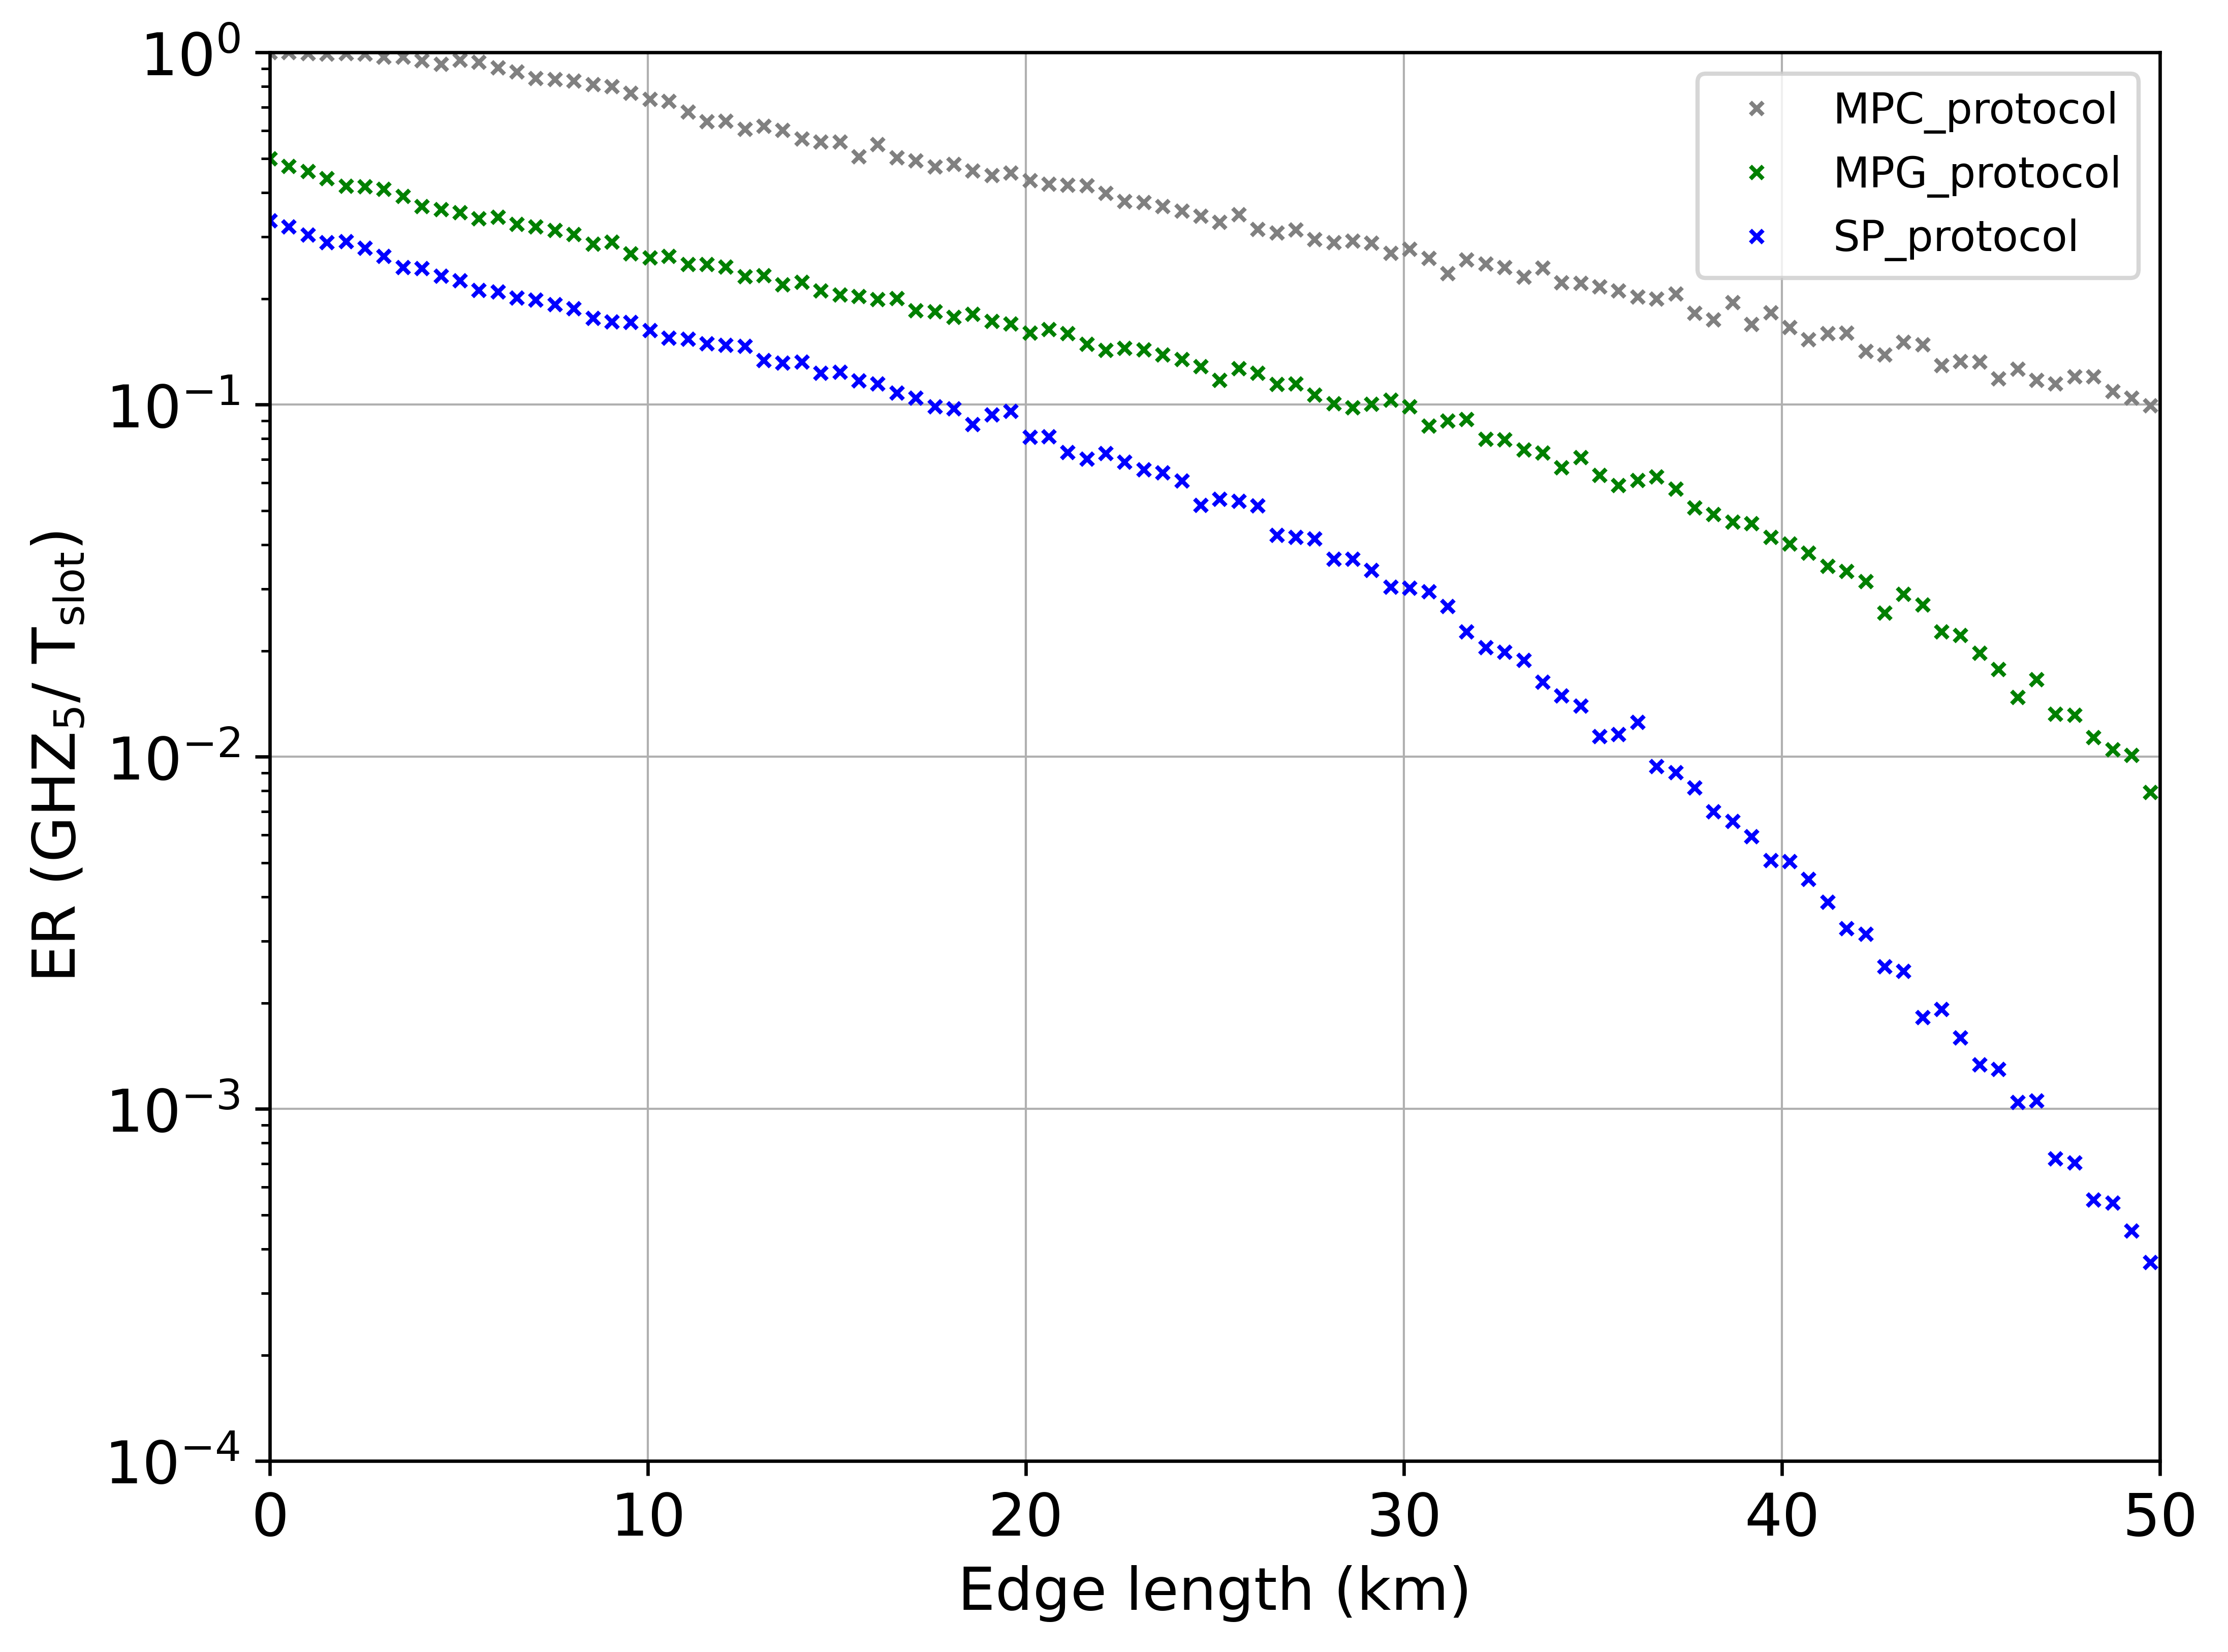

In [5]:
nom_list = [str(p).split(" ")[1] for p in protocols]
plt.figure(figsize=(8, 6), dpi=600)
plt.grid(linewidth=0.5)
for i in range(len(protocols)):
    y = plt.plot(
        length_range,
        ER[i],
        color=cols[i],
        marker="x",
        linestyle="None",
        markersize=3,
        #  alpha = 0.5,
        #  linewidth=linewidth,
        label=nom_list[i],
    )
plt.yscale("log")
plt.legend(fontsize=10)
plt.tick_params(labelsize=fontsize)

plt.xlabel("Edge length (km)", fontsize=fontsize)
plt.ylabel("ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)", fontsize=fontsize)

ax = plt.gca()
ax.set_xlim([0, 50])
ax.set_ylim([0.0001, 1])

plt.savefig("figures/ER_v_length.png", dpi=600)

## Save data

In [6]:
data_to_save = {
    "size": size,
    "Q_c": Q_c,
    "p_op": p_op,
    "loss_dB": loss_dB,
    "datapoints": length_range.size,
    "timesteps": timesteps,
    "reps": reps,
    "users": users,
    "protocols": nom_list,
    "length_range": length_range.tolist(),
    "ER": ER.tolist(),
}

filename = "ER_len/5x5/p_op1/Q10"

with open("data/" + filename + ".json", "w") as file:
    file.write(json.dumps(data_to_save))

## Load and plot data

In [7]:
file_to_open = "ER_len/5x5/p_op1/Q10"
with open("data/" + file_to_open + ".json", "r") as file:
    loaded_data = json.loads(file.read())

# files_to_open = ["5x5/p_op1/Q1_range30", "9x9/Q1", "15x15/Q1", "25x25/Q1"]
# for i, file_name in enumerate(files_to_open):
#     with open("data/ER_len/" + file_name + ".json", "r") as file:
#         loaded_data[i] = json.loads(file.read())

# reduce points
# loaded_data['length_range'][::2]

In [8]:
def length2p_ph(l):
    return 10 ** -(loaded_data["loss_dB"] * l / 10)

def p_ph2length(p):
    return -(np.log10(p) * 10) / loaded_data["loss_dB"]

length2p_e = lambda l: length2p_ph(l) * loaded_data["p_op"]
p_e2length = lambda p: p_ph2length(p / loaded_data["p_op"])

C:\Users\ROG\AppData\Local\Temp\ipykernel_19916\4042839359.py:5: RuntimeWarning: divide by zero encountered in log10
  return -(np.log10(p) * 10) / loaded_data["loss_dB"]


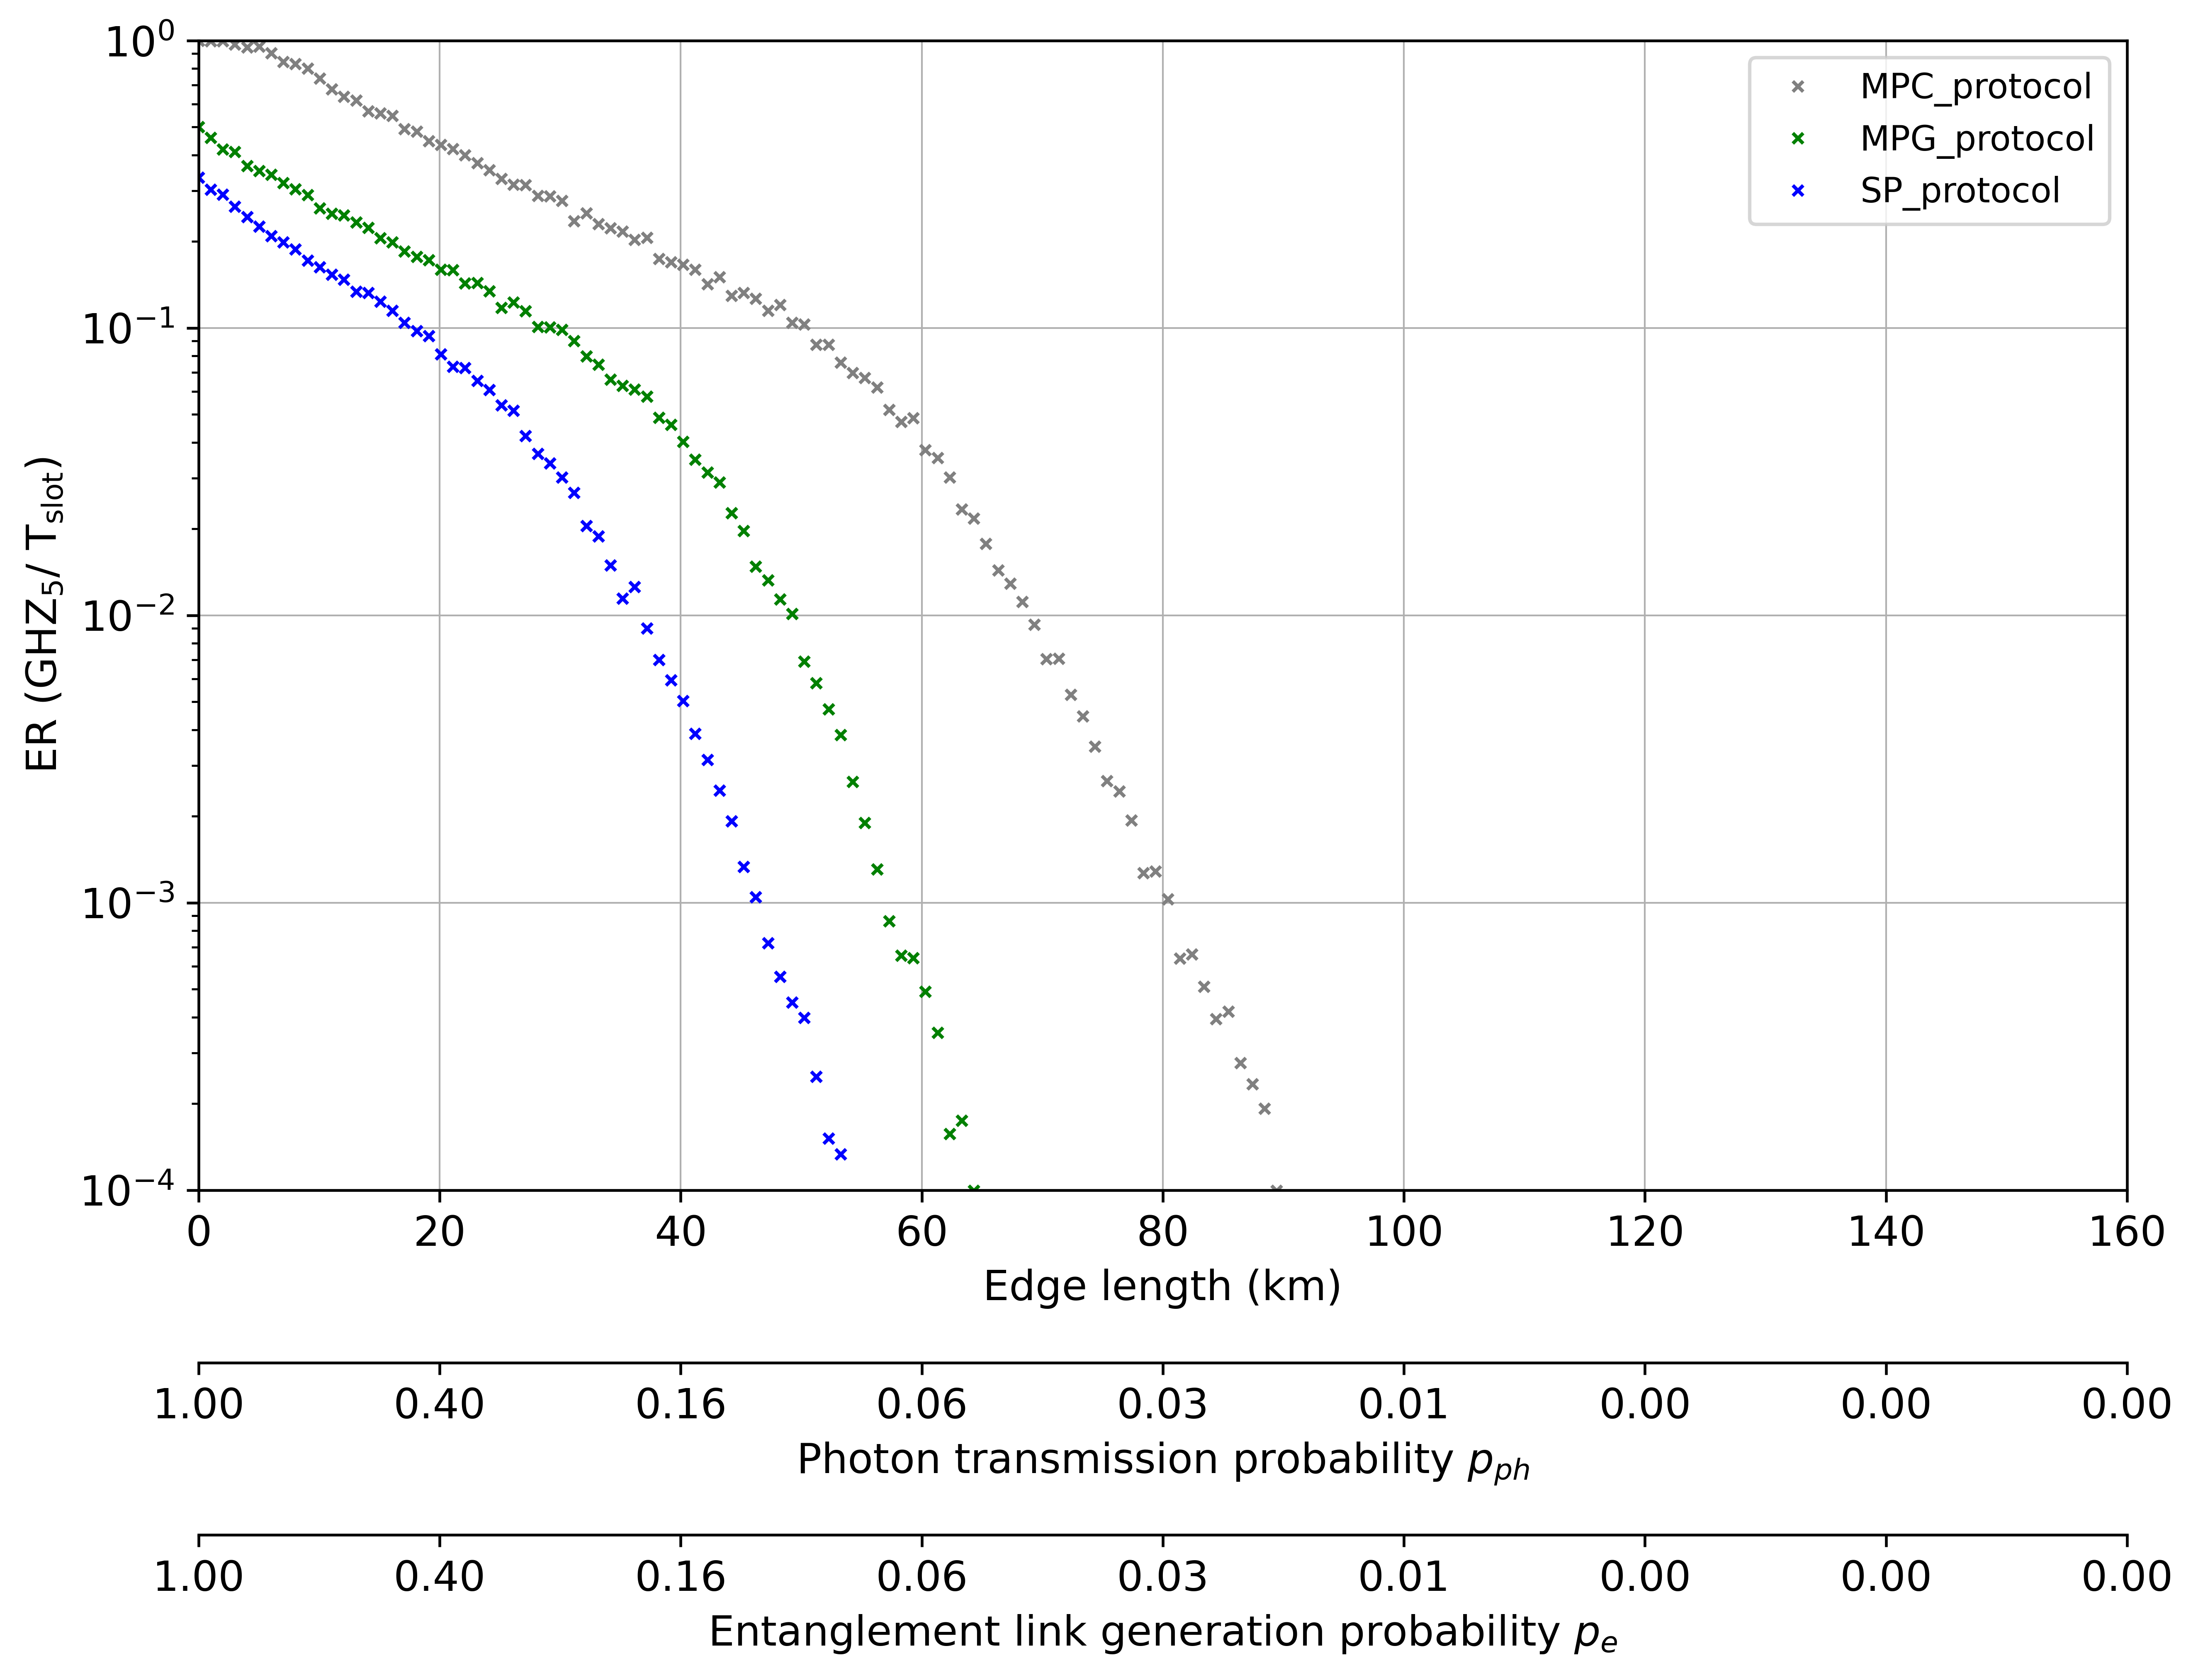

In [9]:
fontsize = 12
# grid_sizes = ["5x5", "9x9", "15x15", "25x25"]
protocol_list = loaded_data["protocols"]
plt.figure(figsize=(10, 6), dpi=600)
plt.grid(linewidth=0.5)
for i in range(len(protocol_list)):
    y = plt.plot(
        loaded_data["length_range"][::2],
        loaded_data["ER"][i][::2],
        color=cols[i],
        marker="x",
        linestyle="None",
        markersize=3,
        #  alpha = 0.5,
        #  linewidth=linewidth,
        label=protocol_list[i],
    )

# plot ER=p line
# plt.plot(
#     np.linspace(0, 160, 200),
#     [length2p_e(l) for l in np.linspace(0, 160, 200)],
#     color="black",
#     linestyle="--",
#     linewidth="1",
#     alpha=0.8,
#     label="$\mathregular{p_e}$",
# )

plt.yscale("log")
plt.legend(fontsize=10)
plt.tick_params(labelsize=fontsize)

plt.xlabel("Edge length (km)", fontsize=fontsize)
plt.ylabel("ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)", fontsize=fontsize)

ax = plt.gca()
ax.set_xlim([0, 160])
ax.set_ylim([0.0001, 1])

ax2 = ax.secondary_xaxis(-0.15, functions=(length2p_ph, p_ph2length))
ax2.set_xlabel("Photon transmission probability $p_{ph}$", fontsize=fontsize)

l_ticks = ax.get_xticks()
p_ph_ticks = length2p_ph(l_ticks)
ax2.set_xticks(p_ph_ticks)
ax2.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax2.xaxis.set_tick_params(labelsize=fontsize)

ax3 = ax.secondary_xaxis(-0.3, functions=(length2p_e, p_e2length))
ax3.set_xlabel("Entanglement link generation probability $p_e$", fontsize=fontsize)

p_e_ticks = length2p_e(l_ticks)
ax3.set_xticks(p_e_ticks)
ax3.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax3.xaxis.set_tick_params(labelsize=fontsize)

plt.savefig("figures/ER_v_length2.png", dpi=600, bbox_inches="tight")

# Links used against length

In [10]:
size = 5
center = (size - 1) / 2
G = network(size, size)
nodes = list(G.nodes)
protocols = [MPC_protocol, MPG_protocol, SP_protocol]

In [11]:
length_range = np.linspace(0, 160, 200)
links_used = np.zeros((len(protocols), len(length_range)))
timesteps = 1000
reps = 200
Q_c = 100000
p_op = 1
loss_dB = 0.2

update_graph_params(G, Qc=Q_c)

n = 1 # 靠近中心的程度，0就是在角落，1就是更靠近中心根号2格

# users = [
#     (center, center),
#     (n, n),
#     (n, size - 1 - n),
#     (size - 1 - n, 0),
#     (size - 1 - n, size - 1 - n),
# ]  # "source" for SP & MPG will be the central node

users = [17, 19, 13, 0, 8]

for i, length in enumerate(tqdm.tqdm(length_range)):  # tqdm_notebook
    set_edge_length(G, length, p_op=p_op, loss_dB=loss_dB)
    for j, function in enumerate(protocols):
        er, multipartite_gen_time, avg_links_used = function(G, users, timesteps=timesteps, reps=reps)
        links_used[j, i] += avg_links_used

  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\ROG\Desktop\quantum_repeaters\simplequantnetsim\protocols.py:95: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn'in version 3.2.
Set the `method` kwarg to remove this warning.
  success = success_protocol(G, H, users, used_nodes, count_fusion)  # protocol specific
100%|██████████| 200/200 [38:06<00:00, 11.43s/it]


## Save data

In [12]:
data_to_save = {
    "size": size,
    "Q_c": Q_c,
    "p_op": p_op,
    "loss_dB": loss_dB,
    "datapoints": length_range.size,
    "timesteps": timesteps,
    "reps": reps,
    "users": users,
    "protocols": [str(p).split(" ")[1] for p in protocols],
    "length_range": length_range.tolist(),
    "links_used": links_used.tolist(),
}

filename = "links_len/5x5/p_op1/QX"

with open("data/" + filename + ".json", "w") as file:
    file.write(json.dumps(data_to_save))

## Load and plot data

In [13]:
file_to_open = "links_len/5x5/p_op1/QX"
with open("data/" + file_to_open + ".json", "r") as file:
    loaded_data = json.loads(file.read())

In [14]:
def length2p_ph(l):
    return 10 ** -(loaded_data["loss_dB"] * l / 10)

def p_ph2length(p):
    return -(np.log10(p) * 10) / loaded_data["loss_dB"]

length2p_e = lambda l: length2p_ph(l) * loaded_data["p_op"]
p_e2length = lambda p: p_ph2length(p / loaded_data["p_op"])

C:\Users\ROG\AppData\Local\Temp\ipykernel_19916\4042839359.py:5: RuntimeWarning: divide by zero encountered in log10
  return -(np.log10(p) * 10) / loaded_data["loss_dB"]


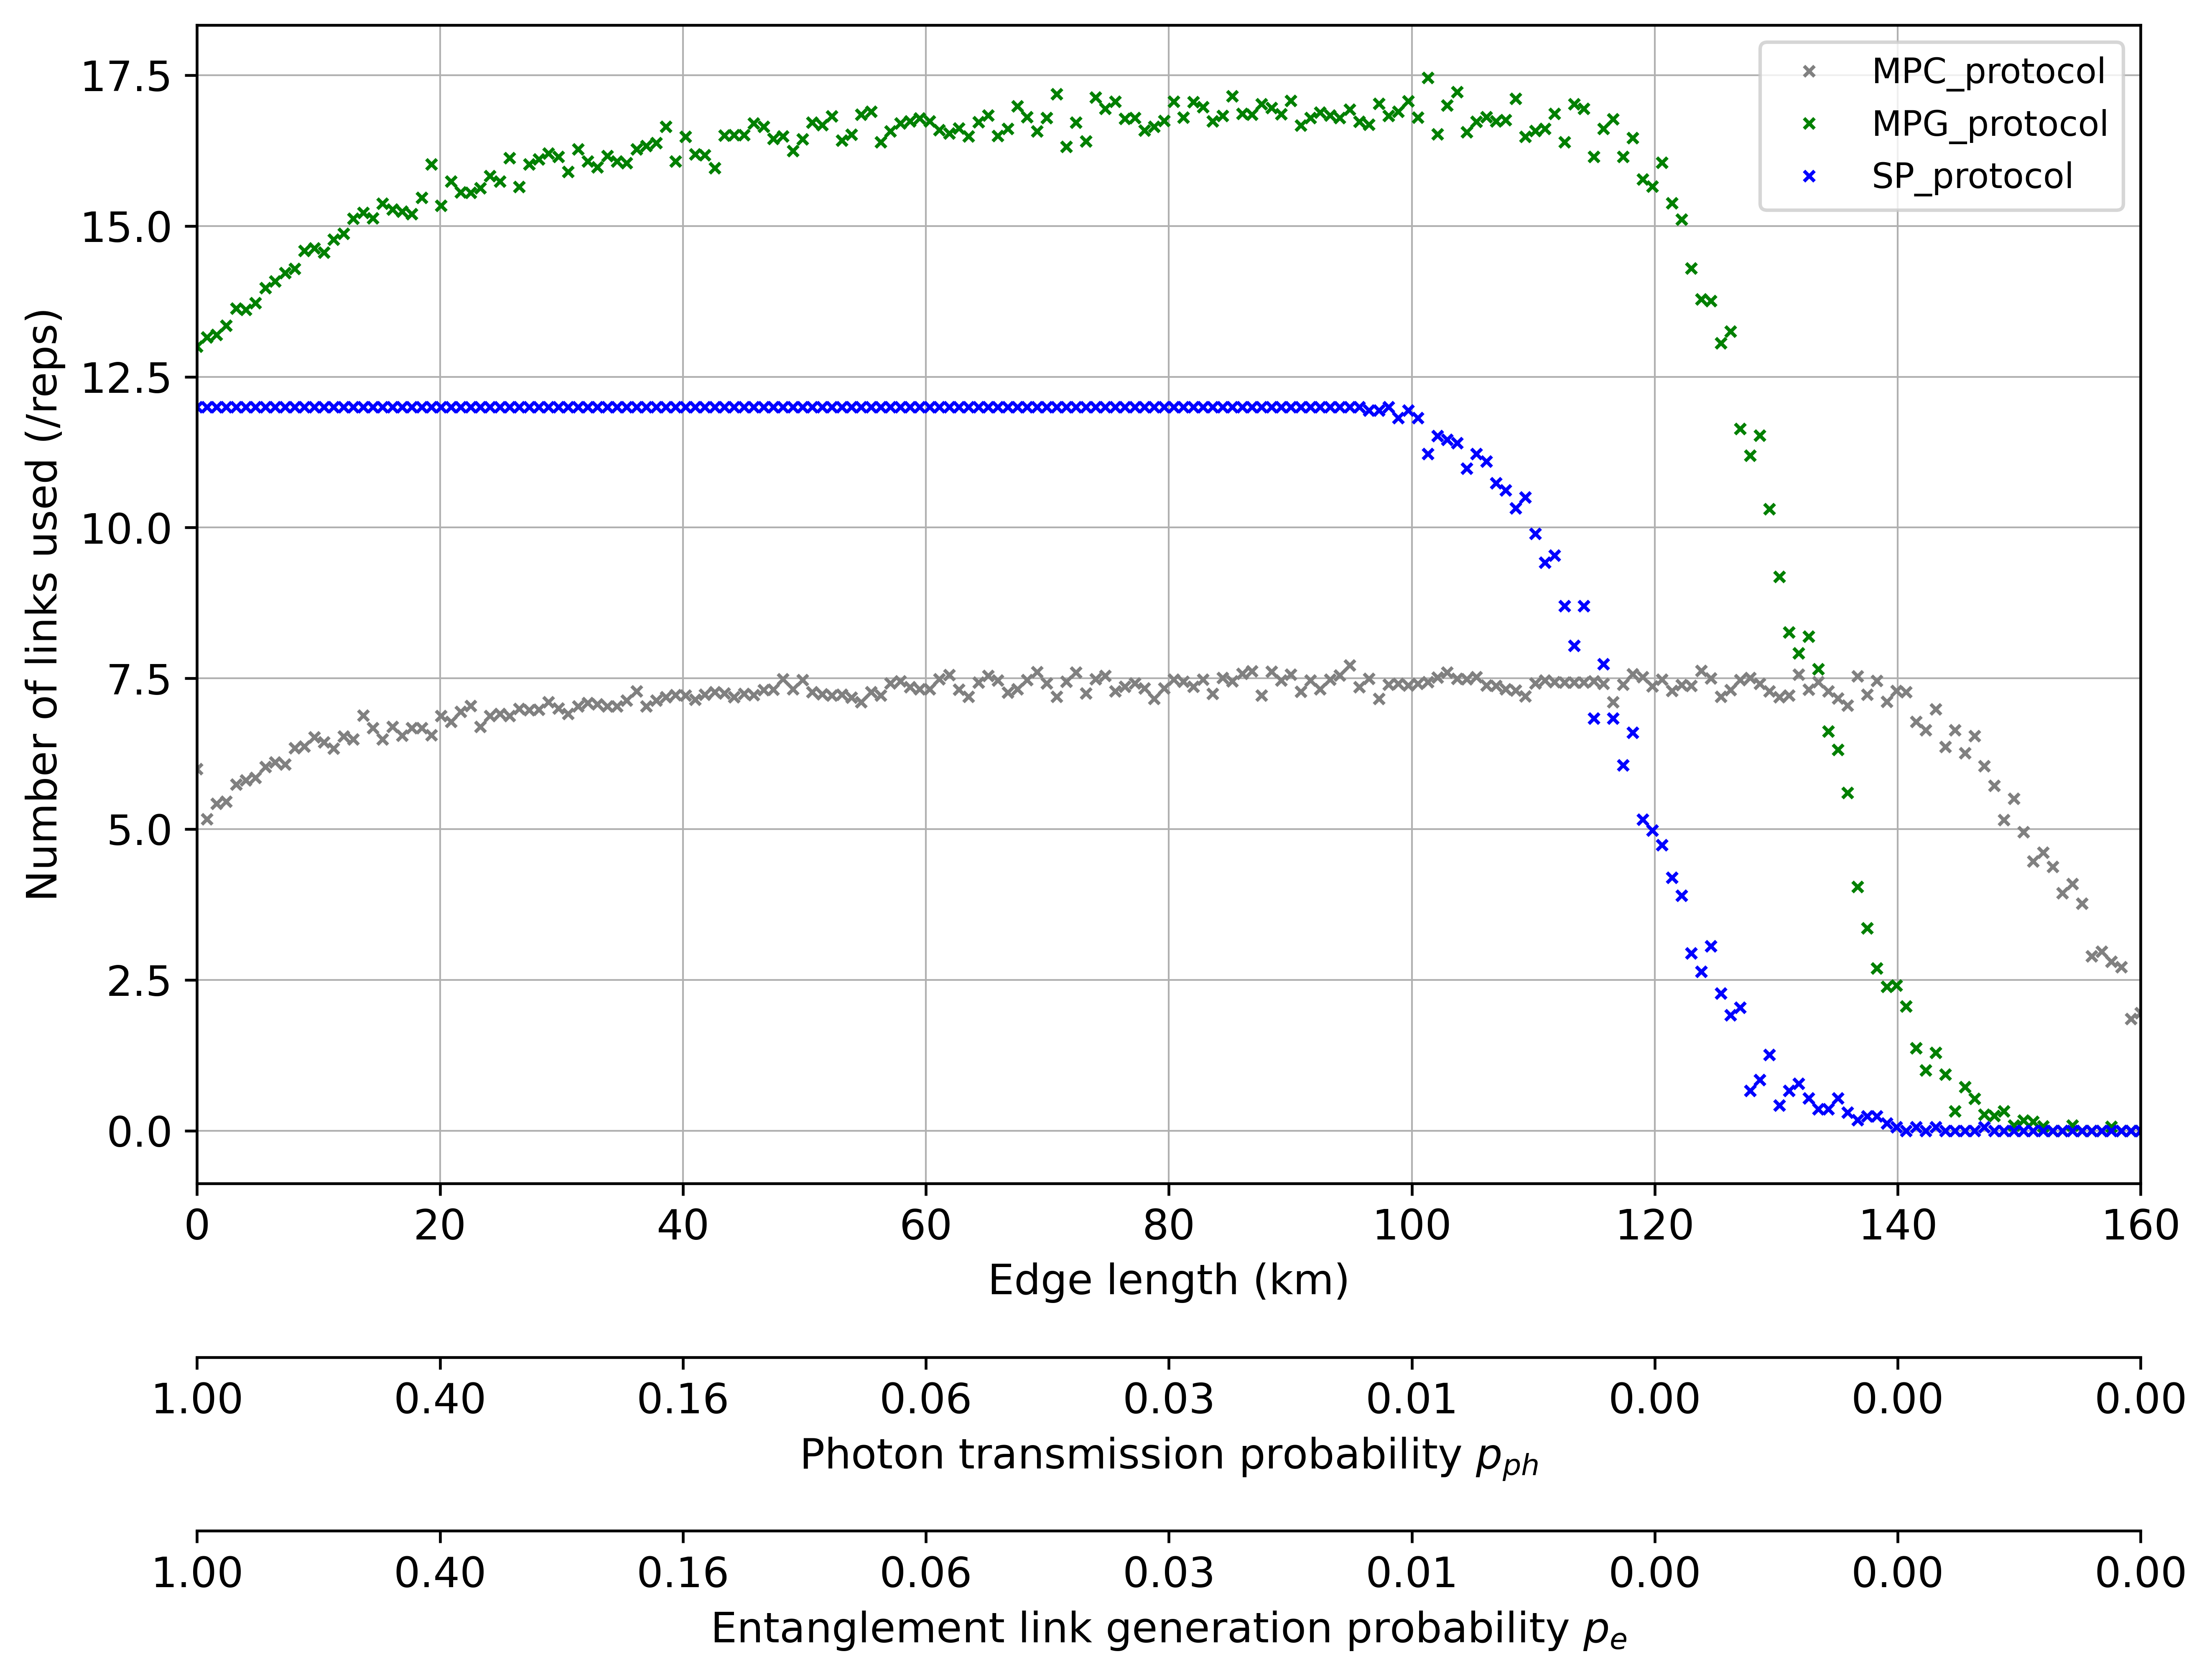

In [15]:
fontsize = 12
protocol_list = loaded_data["protocols"]
plt.figure(figsize=(10, 6), dpi=600)
plt.grid(linewidth=0.5)
for i in range(len(protocol_list)):
    y = plt.plot(
        loaded_data["length_range"],
        loaded_data["links_used"][i],
        color=cols[i],
        marker="x",
        linestyle="None",
        markersize=3,
        label=protocol_list[i],
    )

# plt.yscale("log")
plt.legend(fontsize=10)
plt.tick_params(labelsize=fontsize)

plt.xlabel("Edge length (km)", fontsize=fontsize)
plt.ylabel("Number of links used (/reps)", fontsize=fontsize)

ax = plt.gca()
ax.set_xlim([0, 160])
# ax.set_ylim([0.0001, 1])

ax2 = ax.secondary_xaxis(-0.15, functions=(length2p_ph, p_ph2length))
ax2.set_xlabel("Photon transmission probability $p_{ph}$", fontsize=fontsize)

l_ticks = ax.get_xticks()
p_ph_ticks = length2p_ph(l_ticks)
ax2.set_xticks(p_ph_ticks)
ax2.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax2.xaxis.set_tick_params(labelsize=fontsize)

ax3 = ax.secondary_xaxis(-0.3, functions=(length2p_e, p_e2length))
ax3.set_xlabel("Entanglement link generation probability $p_e$", fontsize=fontsize)

p_e_ticks = length2p_e(l_ticks)
ax3.set_xticks(p_e_ticks)
ax3.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax3.xaxis.set_tick_params(labelsize=fontsize)

plt.savefig("figures/links_v_length.png", dpi=600, bbox_inches="tight")